# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [227]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from plotnine import *

# Chi-squared test
from scipy.stats import chi2_contingency

# Models, metrics and GridSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score,f1_score


from catboost import CatBoostClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [194]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Jose Yanez\AppData\Local\Temp\ipykernel_4884\2693282953.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\Jose Yanez\AppData\Local\Temp\ipykernel_4884\2693282953.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
extra_cols = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


## Explotarory Analysis AZDIAS Dataset 

Questions driving the exploratory data analysis: 

1. What's the age distribution in AZDIAS and CUSTOMERS? 
2. There's information about socioeconomical status of customers? 
3. 

In [4]:
# Exploratory Data Analysis

print(azdias.shape)

print(customers.shape)

#print(azdias.columns.values)

(891221, 366)
(191652, 369)


C:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 46596 rows containing non-finite values.


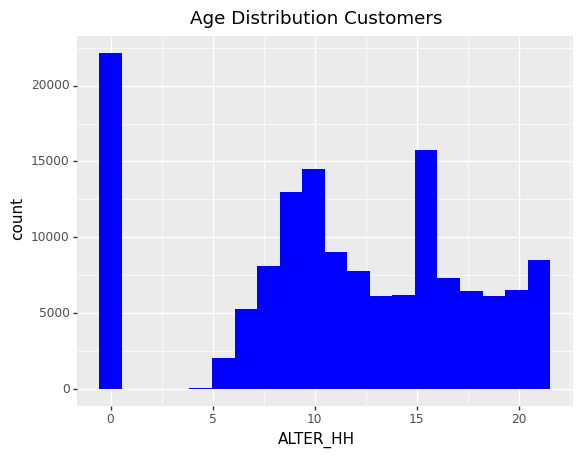

<ggplot: (143065582912)>

In [214]:
# Age distribution in Customers
# ALTER_HH definition: main age within the household
(ggplot(customers, aes(x='ALTER_HH')) + 
 geom_histogram(bins=20, fill = 'b') +
 ggtitle('Age Distribution Customers'))


C:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 73499 rows containing non-finite values.


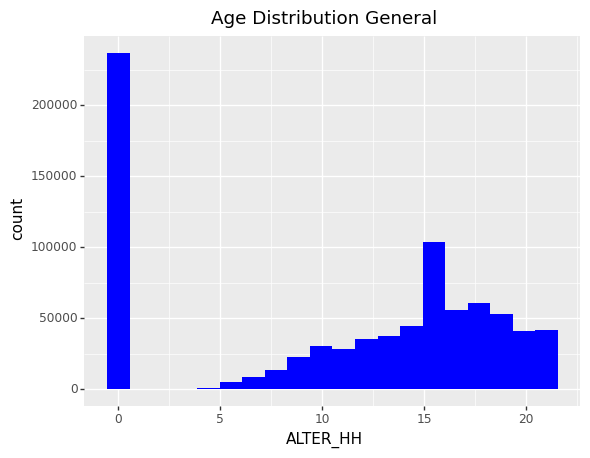

<ggplot: (143066229264)>

In [215]:
(ggplot(azdias, aes(x='ALTER_HH')) + 
 geom_histogram(bins=20, fill = 'b') +
 ggtitle('Age Distribution General'))


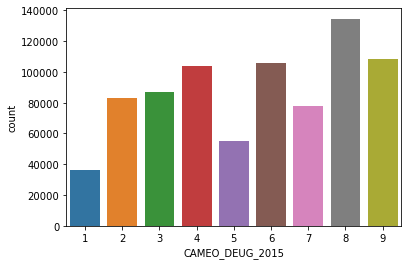

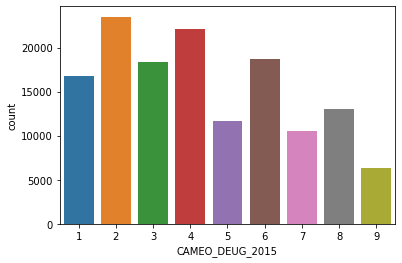

In [7]:
# 2. There's information about socioeconomical status of customers? 
# The field CAMEO_DEUG_2015 refers to the CAMEO classificiation 
# -1 is missing values and other numerical values are proportional to economical status
dic_1 = pd.DataFrame({'original'})

pl1 = azdias[(~azdias['CAMEO_DEUG_2015'].isna()) & (azdias['CAMEO_DEUG_2015']!= 'X')]['CAMEO_DEUG_2015'].apply(int)
pl1.head()
sns.countplot(x = pl1)
plt.show()
pl1 = customers[(~customers['CAMEO_DEUG_2015'].isna()) & (customers['CAMEO_DEUG_2015']!= 'X')]['CAMEO_DEUG_2015'].apply(int)
pl1.head()
sns.countplot(x = pl1)
plt.show()

## Data Preprocessing and Cleaning

General steps in this sections are:
1. Create column customer
3. Check the columns described in the dictionary and drop those missing
4. Load 

In [8]:
# Columns in DIAS Information Levesl

data_dictionary  = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', sheet_name = 'Hoja1' )

print(data_dictionary.head())

described_attributes = list(data_dictionary['Attribute'])
print(len(described_attributes)) #The file has 318 attributes documented

# List of non described attributes 

print(described_attributes)
non_described_attributes = set(azdias.columns)-set(described_attributes)
non_described_attributes







#Source: https://stackoverflow.com/questions/6696027/how-to-split-elements-of-a-list

              Attribute
0              AGER_TYP
1  ALTERSKATEGORIE_GROB
2             ANREDE_KZ
3         CJT_GESAMTTYP
4     FINANZ_MINIMALIST
318
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE', 'D19_KK_KUNDENTYP', 'D19_KONSUMTYP', 'D19_GESAMT_ANZ_12', '

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 'D19_VERSI_O

In [9]:
print(len(customers.columns.values))
customers.columns.values

369


array(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE',
       'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DA

In [10]:
len(non_described_attributes)

92

In [11]:
# Drop columns non described 

print(f"azdias has {len(azdias.columns)} columns")
azdias.drop(columns = non_described_attributes, inplace = True)
#customers.drop(columns = non_described_attributes, inplace = True)
print(f"updated azdias has {len(azdias.columns)} columns")


azdias has 366 columns
updated azdias has 274 columns


In [12]:
# Loading file with description of coded unkown values (-1, 0, 9, etc)
coded_mv = pd.read_excel('coded_missing_values.xlsx')
coded_mv['Attribute']

#Cols in coded_mv but not in azdias
set(coded_mv['Attribute'])-set(azdias.columns) 

# 10 columns are documented but are also missing from azdias dataset


{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_KK_KUNDENTYP',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'KBA13_CCM_3000',
 'KBA13_CCM_3001',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB',
 nan}

In [13]:
## Replacing -1, 0 and 9 according to the coded missing values (coded_mv)

import time
start_time = time.time()


## For A type columns I need to replace -1 to np.nan

for j in set(coded_mv['Replace_Type']):
    print(j)
    cols_replace = set(coded_mv[coded_mv['Replace_Type']==j]['Attribute']).intersection(set(azdias.columns))
    for column in cols_replace:
        if j in ('A','C','D','E'):
            azdias[column] = azdias[column].replace(-1,np.nan)
            #print(f'Reemplazar -1 a nan en la columna{column}')
        if j in ('B','D'):
            azdias[column] = azdias[column].replace(0,np.nan)
            #print(f'Reemplazar 0 a nan en la columna{column}')
        if j in ('E'):
            azdias[column] = azdias[column].replace(9,np.nan)
            #print(f'Reemplazar 9 a nan en la columna{column}')
        
        
print("--- %s seconds ---" % (time.time() - start_time))
        
        


A
C
B
E
D
--- 48.532920598983765 seconds ---


In [14]:
# Analyzing the presence of other strange values in the dataset
dif_values = []
for column in azdias.columns:
    print(column)
    #print(df[column].value_counts(dropna=False))
    print(azdias[column].value_counts(dropna=False).index)
    dif_values.append(azdias[column].value_counts(dropna=False).index.values)

# 1. This shows the existence of "X" values in column CAMEO_DUG_2015 
# 2. There are also 'XX' in column CAMEO_DEU_2015
# 3. There are mixed datatype in columns (ints with floats or str with integers)



AGER_TYP
Float64Index([nan, 2.0, 1.0, 3.0, 0.0], dtype='float64')
ALTER_HH
Float64Index([ nan, 18.0, 17.0, 19.0, 15.0, 16.0, 14.0, 21.0, 20.0, 13.0, 12.0,
              10.0, 11.0,  9.0,  8.0,  7.0,  6.0,  5.0,  4.0,  3.0,  2.0,
               1.0],
             dtype='float64')
ANZ_HAUSHALTE_AKTIV
Float64Index([  1.0,   2.0,   nan,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,
                9.0,
              ...
              293.0, 226.0, 254.0, 404.0, 237.0, 213.0, 366.0, 220.0, 536.0,
              232.0],
             dtype='float64', length=293)
ANZ_HH_TITEL
Float64Index([ 0.0,  nan,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  8.0,  7.0,  9.0,
              13.0, 12.0, 11.0, 14.0, 10.0, 17.0, 20.0, 15.0, 18.0, 16.0,
              23.0],
             dtype='float64')
ANZ_PERSONEN
Float64Index([ 1.0,  2.0,  3.0,  nan,  4.0,  0.0,  5.0,  6.0,  7.0,  8.0,  9.0,
              10.0, 11.0, 12.0, 13.0, 21.0, 14.0, 20.0, 15.0, 23.0, 22.0, 38.0,
              37.0, 29.0, 31.0, 45.0, 18.0, 35.0, 17

In [15]:
# Cleaning of X and XX values
print(sum(azdias['CAMEO_DEUG_2015']=='X')) #Number of 'X' in CAMEO_DEUG_2015
azdias['CAMEO_DEUG_2015'].replace('X',np.nan, inplace = True)
print(sum(azdias['CAMEO_DEUG_2015']=='X'))

print(sum(azdias['CAMEO_DEU_2015']=='XX')) #Number of 'XX' in CAMEO_DEU_2015
azdias['CAMEO_DEU_2015'].replace('XX',np.nan, inplace = True)
print(sum(azdias['CAMEO_DEU_2015']=='XX'))







373
0
373
0


In [16]:
'CAMEO_DEUG_2015' in customers.columns

True

In [17]:
# Checking datatypes and converting ints to float 
print(azdias.dtypes.value_counts()) #220 float, 51 int and 3 object
azdias.columns[azdias.dtypes == 'object']

float64    220
int64       51
object       3
dtype: int64


Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object')

In [18]:
#Converting int columns to float: 

for col in azdias.columns:
    if azdias[col].dtypes == 'int64':
        azdias[col] = azdias[col].astype(float)
        

        

In [19]:
#Checking the columns with type 'object'

object_cols = azdias.loc[:,azdias.dtypes=='object'].columns
print(object_cols) #CAMEO_DEU_2015, CAMEO_DEUG_2015 & OST_WEST_KZ


for col in object_cols:
    print(f'Column {col} has {azdias[col].nunique()} different values')

# Considering the step of OneHotEncoding I'll drop the first two columns due to a high number of categories

azdias.drop(columns = ['CAMEO_DEU_2015','CAMEO_DEUG_2015'], inplace = True)



Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object')
Column CAMEO_DEU_2015 has 44 different values
Column CAMEO_DEUG_2015 has 18 different values
Column OST_WEST_KZ has 2 different values


In [20]:
#Encoding OST_WEST_KZ

azdias['OST_WEST_KZ'].value_counts()
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 0})
azdias['OST_WEST_KZ'].value_counts()



1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


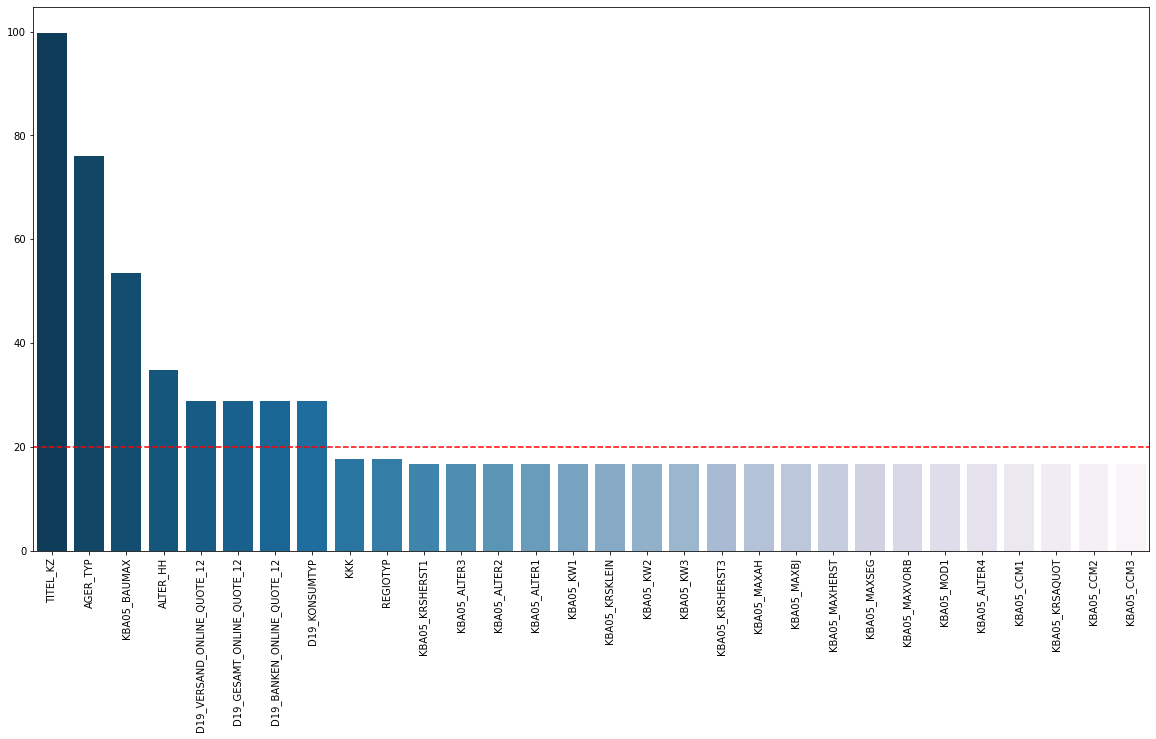

In [21]:
# Analyzing columns with high percentage of missing values

percent_mv = (azdias.isnull().sum() * 100 / len(azdias)).sort_values(ascending = False)

plt.figure(figsize = (20,10))
plt.axhline(y=20, color='r', linestyle='--')

sns.barplot(percent_mv.nlargest(30).index, percent_mv.nlargest(30).values, palette='PuBu_r')
plt.tick_params(axis='x', rotation=90)

cols_high_mv = percent_mv[percent_mv >= 20].index



In [22]:
# Deleting columns with high percentage of missing values
print(len(azdias.columns))
azdias.drop(columns = cols_high_mv, inplace=True)
print(len(azdias.columns))

272
264


Int64Index([     0,     11,     14,     15,     17,     20,     23,     24,
                26,     30,
            ...
            891154, 891159, 891164, 891170, 891171, 891172, 891173, 891175,
            891185, 891187],
           dtype='int64', length=105863)


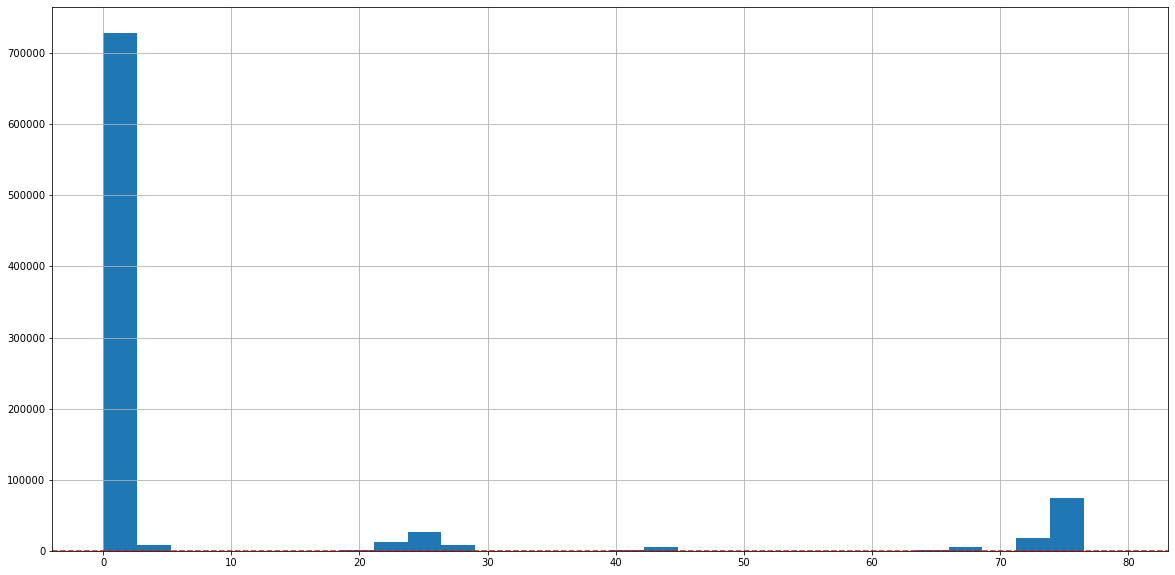

In [23]:
# Analyzing rows with high percentage of missing values

percent_mv_row = (azdias.isnull().sum(axis=1) * 100 / len(azdias.columns))

percent_mv_row.values
plt.figure(figsize = (20,10))
plt.axhline(y=20, color='r', linestyle='--')


percent_mv_row.hist(bins=30) #This show a significant number of rows with more than 30% of missing values 

rows_high_mv = percent_mv_row[percent_mv_row >= 30].index
print(rows_high_mv)




In [24]:
# Drop rows with more than 30% of missing values

print(len(azdias))
azdias.drop(index = rows_high_mv, inplace = True)
print(len(azdias))

891221
785358


In [25]:
# Imputation of missing values with the median 

from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

azdias_imputed = imp_median.fit_transform(azdias.values)




In [26]:
# Scaling 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)


In [27]:
# PCA AZDIAS

from sklearn.decomposition import PCA

pca = PCA()

azdias_pca = pca.fit_transform(azdias_scaled)



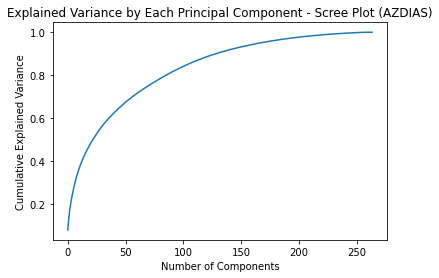

In [28]:
data = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.title('Explained Variance by Each Principal Component - Scree Plot (AZDIAS)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

In [29]:
# Creating a cleaning function 

def all_preprocessing(df, described_atributes,coded_mv, cols_high_mv):
    
    """
    Returns a cleaned dataframe
    
    INPUT:
    
    RETURN:
    dataframe 
    """
    
    # 1. Deleting extra columns:
    extra_cols = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
    if set(extra_cols).issubset(df.columns):
        df.drop(columns = extra_cols, inplace = True)
    
    
    # 2. Deleting non described columns:
    non_described_cols = set(df.columns)-set(described_atributes)
    df.drop(columns = non_described_cols, inplace = True)
    
    
    # 3. Replacing documented missing values:
    
    for j in set(coded_mv['Replace_Type']):
        #print(j)
        cols_replace = set(coded_mv[coded_mv['Replace_Type']==j]['Attribute']).intersection(set(df.columns))
        for column in cols_replace:
            if j in ('A','C','D','E'):
                df[column] = df[column].replace(-1,np.nan)
            if j in ('B','D'):
                df[column] = df[column].replace(0,np.nan)
            if j in ('E'):
                df[column] = df[column].replace(9,np.nan)
    
    
    # 4. Cleaning 'X' and 'XX' values
    
    if 'CAMEO_DEUG_2015' in df.columns:
        df['CAMEO_DEUG_2015'].replace('X',np.nan, inplace = True)
        
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'].replace('XX',np.nan, inplace = True)
    
    
    # 5. Converting columns with datatype "int" to "float"
    for col in df.columns:
        if df[col].dtypes == 'int64':
            df[col] = df[col].astype(float)
        
    # 6. Temporal. Dropping 'CAMEO_DEU_2015' & 'CAMEO_DEUG_2015'
    
    df.drop(columns = ['CAMEO_DEU_2015','CAMEO_DEUG_2015'], inplace = True)
    
    
    # 7. Mapping OST_WEST
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    # 8. Deleting columns with high percentage of missing values
    
    df.drop(columns = cols_high_mv, inplace = True)
    
    # 9. Deleting rows with high percentage of missing values
    
    percent_mv_row = (df.isnull().sum(axis=1) * 100 / len(df.columns))
    rows_high_mv = percent_mv_row[percent_mv_row >= 30].index
    df.drop(index = rows_high_mv, inplace = True)
    
    # 10. Imputation of missing values
    
    imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
    df_clean = pd.DataFrame(imp_median.fit_transform(df.values))
    df_clean.columns = df.columns
    df_clean.index = df.index
    
    
    
    
    
    return df_clean
    
    

In [30]:
## Apply cleaning function to the customers dataset
customer_clean = all_preprocessing(customers, described_attributes,coded_mv, cols_high_mv)



In [31]:
azdias_pca.shape
azdias_pca[:,0:150].shape

(785358, 150)

In [32]:
# Comparing columns in azdias and customers

print(set(azdias.columns) - set(customer_clean.columns))

# Result: both dataset has the same columns
azdias.shape

set()


(785358, 264)

In [33]:
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customer_clean)
pca = PCA()
customers_pca = pca.fit_transform(customers_scaled)

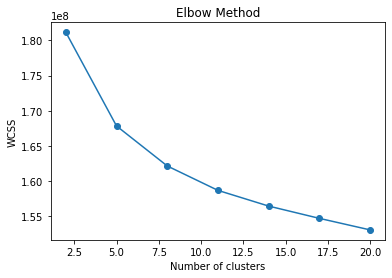

In [34]:
# K-MEANS
from sklearn.cluster import KMeans
# limiting the range of clusters due to a high time of processing
n_clusters = [2,5,8,11,14,17,20]

def multiple_kmeans(data,n_clusters):
    wcss = []
    for i in n_clusters:
        print(f'K-means for {i} clusters')
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=3, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

#wcss = multiple_kmeans(customers_pca[:,0:150],n_clusters)

    

# Store data 
#with open('wcss.pickle', 'wb') as handle:
#    pickle.dump(wcss, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data 
with open('wcss.pickle', 'rb') as handle:
    wcss = pickle.load(handle)
    

plt.plot(n_clusters, wcss,marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [35]:
# This part of the code took 20 minutes aprox so I saved the results in .pkl files 

# K=11 

#start_time = time.time()
        
#kmeans = KMeans(11, random_state=0)
#azdias_clust = kmeans.fit_predict(azdias_pca[:,0:150])
#customers_clust = kmeans.predict(customers_pca[:,0:150])
# Storing K-MEANS

#with open('azdias_clust.pickle', 'wb') as handle:
#    pickle.dump(azdias_clust, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('customers_clust.pickle', 'wb') as handle:
#    pickle.dump(customers_clust, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#print("--- %s seconds ---" % (time.time() - start_time))

In [36]:
# Loading files with Clusters
 
with open('azdias_clust.pickle', 'rb') as handle:
    clus1 = pickle.load(handle)
    
    
with open('customers_clust.pickle', 'rb') as handle:
    clus2 = pickle.load(handle)
    
    

In [38]:

clus1pd = pd.DataFrame(clus1, columns = ["Cluster"])
clus1pd["Set"] = "General"
clus2pd = pd.DataFrame(clus2, columns = ["Cluster"])
clus2pd["Set"] = "Customers"

clusters = pd.concat([clus1pd,clus2pd])
#ax = sns.countplot(x="Cluster", hue="Set", data=clusters)

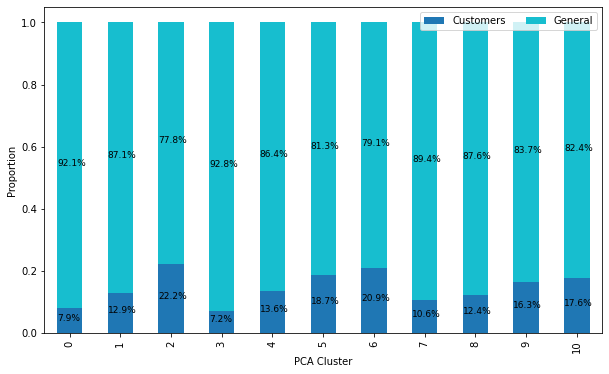

In [39]:

cross_tab_prop = pd.crosstab(index=clusters['Cluster'],
                             columns=clusters['Set'],
                             normalize="index")
cross_tab_prop

cross_tab = pd.crosstab(index=clusters['Cluster'],
                        columns=clusters['Set'])
cross_tab

cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

plt.legend(loc="upper right", ncol=2)
plt.xlabel("PCA Cluster")
plt.ylabel("Proportion")

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.25,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=9,
                 fontweight="normal")

plt.show()

# Credits to KSV Muralidhar who posted a tutorial for this plot here:
# https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b

In [40]:
# clusters.plot(kind='bar', stacked=True, color=['red', 'skyblue'])


## EDA Training Set



In [41]:
train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


C:\Users\Jose Yanez\AppData\Local\Temp\ipykernel_4884\2831755958.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [42]:
print(train.shape)
print(train.columns)


(42962, 367)
Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'RESPONSE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=367)


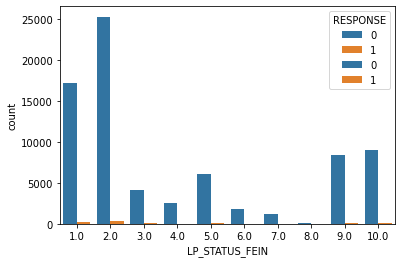

In [43]:
sns.countplot(x="ANREDE_KZ", hue="RESPONSE", data=train);
sns.countplot(x="LP_STATUS_FEIN", hue="RESPONSE", data=train);



## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [44]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Jose Yanez\AppData\Local\Temp\ipykernel_4884\3492614913.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [45]:
print(mailout_train.head())
print(mailout_train.info())
y = mailout_train['RESPONSE']

    LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   8.0                 15.0  ...   
1          NaN          NaN                  13.0                  1.0  ...   
2          NaN          NaN                   7.0                  0.0  ...   
3          NaN          NaN                   6.0                  4.0  ...   
4          NaN          NaN                   9.0                 53.0  ...   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       5.0         2.0      1.0

In [46]:
mailout_train['RESPONSE'].describe()

count    42962.000000
mean         0.012383
std          0.110589
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RESPONSE, dtype: float64

In [47]:
# Cleaning the training dataset

# 1. Replacing missing values

def replace_mv(df,coded_mv):
    for j in set(coded_mv['Replace_Type']):
        cols_replace = set(coded_mv[coded_mv['Replace_Type']==j]['Attribute']).intersection(set(df.columns))
        #print(cols_replace)
    for column in cols_replace:
        if j in ('A','C','D','E'):
            df[column] = df[column].replace(-1,np.nan)
        if j in ('B','D'):
            df[column] = df[column].replace(0,np.nan)
        if j in ('E'):
            df[column] = df[column].replace(9,np.nan)
    return df
            

def preprocessing_train(df):
    # Cols to keep (due to feature engineering with chi-squared tests):
    
    cols_to_keep = ['D19_SOZIALES','D19_KONSUMTYP_MAX','ANZ_HAUSHALTE_AKTIV',
                    'CAMEO_DEU_2015','D19_KONSUMTYP','RT_SCHNAEPPCHEN']
    
    df['D19_SOZIALES'] = df['D19_SOZIALES'].map({1.0: 1}).fillna(0).astype(int)
    
    df['D19_KONSUMTYP_MAX'] = df['D19_KONSUMTYP_MAX'].map({2:1}).fillna(0).astype(int)
    
    dict_anz = {1.0:1,3.0:1,4.0:1,5.0:1,8.0:1,9.0:1}
    df['ANZ_HAUSHALTE_AKTIV'] = df['ANZ_HAUSHALTE_AKTIV'].map(dict_anz).fillna(0).astype(int)
    
    dict_cameo = {'8A':1, '6B':1,'4C':1,'3D':1,
              '3C':1,'2D':1,'5D':1,'1A':1,
              '1E':1,'1B':1,'9C':1,'9D':1,
              '5B':1,'5C':1,'2A':1,'5A':1,
              '7C':1}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].map(dict_cameo).fillna(0).astype(int)
    
    
    dict_d19konsumtyp = {1.0:1,2.0:2,3.0:3}
    
    df['D19_KONSUMTYP'] = df['D19_KONSUMTYP'].map(dict_d19konsumtyp).fillna(0).astype(int)
    
    
    dict_RT_SCHNAEPPCHEN = {5.0: 2, 1.0: 1, 2.0: 1, 3.0:1, 4.0:1}
    df['RT_SCHNAEPPCHEN'] = df['RT_SCHNAEPPCHEN'].map(dict_RT_SCHNAEPPCHEN).fillna(0).astype(int)
    


    
    
    # Dropping non described columns
    non_described_cols = set(df.columns)-set(described_attributes)-set(cols_to_keep)
    print(non_described_cols)
    df.drop(columns = non_described_cols, inplace = True)
        
    #  Converting columns with datatype "int" to "float"
    for col in df.columns:
        if df[col].dtypes == 'int64':
            df[col] = df[col].astype(float)
        
    #  Dropping 'CAMEO_DEU_2015'
    
    df.drop(columns = ['CAMEO_DEUG_2015'], inplace = True)
    
    
    # Mapping OST_WEST
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    return df


revisar = replace_mv(mailout_train, coded_mv)
df = preprocessing_train(revisar)

# Columns with high % of missing values


percent_mv = (df.isnull().sum() * 100 / len(df)).sort_values(ascending = False)
cols_high_mv = percent_mv[percent_mv >= 20].index
print(cols_high_mv)

def high_mv_imputation(df, cols_high_mv):
    df.drop(columns = cols_high_mv)
    imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
    df_clean = pd.DataFrame(imp_median.fit_transform(df.values))
    df_clean.columns = df.columns
    df_clean.index = df.index
    
    return df_clean
    
train_1 = high_mv_imputation(df,cols_high_mv)
train_1.info()



{'KBA13_ANTG2', 'D19_TELKO_ONLINE_QUOTE_12', 'UMFELD_JUNG', 'STRUKTURTYP', 'D19_TIERARTIKEL', 'D19_REISEN', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND2', 'KONSUMZELLE', 'CAMEO_INTL_2015', 'D19_BUCH_CD', 'D19_GARTEN', 'D19_DIGIT_SERV', 'ALTERSKATEGORIE_FEIN', 'D19_BEKLEIDUNG_REST', 'HH_DELTA_FLAG', 'D19_SCHUHE', 'D19_BANKEN_LOKAL', 'KK_KUNDENTYP', 'D19_DROGERIEARTIKEL', 'D19_VERSICHERUNGEN', 'KBA13_CCM_3001', 'D19_LOTTO', 'VHN', 'SOHO_KZ', 'VERDICHTUNGSRAUM', 'RESPONSE', 'ANZ_KINDER', 'CJT_TYP_4', 'D19_BANKEN_DIREKT', 'VK_ZG11', 'KBA13_GBZ', 'CJT_TYP_3', 'D19_HAUS_DEKO', 'D19_TELKO_REST', 'UNGLEICHENN_FLAG', 'D19_RATGEBER', 'D19_NAHRUNGSERGAENZUNG', 'KBA13_KMH_210', 'KOMBIALTER', 'KBA13_HHZ', 'D19_BEKLEIDUNG_GEH', 'VK_DISTANZ', 'D19_KOSMETIK', 'AKT_DAT_KL', 'MOBI_RASTER', 'D19_ENERGIE', 'VK_DHT4A', 'KBA13_BAUMAX', 'LNR', 'D19_KINDERARTIKEL', 'UMFELD_ALT', 'RT_UEBERGROESSE', 'ALTER_KIND4', 'D19_BILDUNG', 'CJT_TYP_5', 'DSL_FLAG', 'D19_HANDWERK', 'EINGEFUEGT_AM', 'D19_LEBENSMITTEL', 'KBA13_A

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_1, y, test_size=0.2, random_state=0)

In [88]:
# Base Catboost Model

catboost_base = CatBoostClassifier(random_seed = 278, custom_loss='AUC', silent = True)
catboost_base.fit(X_train,y_train)




In [231]:
# Performance on test set

print(f"AUC: {roc_auc_score(y_test, catboost_base.predict_proba(X_test)[:,1])}")
print(f"F1-score:  {f1_score(y_test, catboost_base.predict(X_test))}")
      


AUC: 0.7535118977500295
F1-score:  0.0


In [140]:
# Hiperparameter tuning for Catboost

clf = CatBoostClassifier(random_seed = 278, custom_loss='AUC', silent = True, scale_pos_weight=30)

grid = {'learning_rate': [0.03, 0.02],
        'depth': [4,7],
        'l2_leaf_reg': [1, 9, 13]}

Grid_CBC = GridSearchCV(estimator=clf, param_grid = grid, cv = 3, n_jobs=-1, scoring = "roc_auc")
Grid_CBC.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021295D07E20>,
             n_jobs=-1,
             param_grid={'depth': [4, 7], 'l2_leaf_reg': [1, 9, 13],
                         'learning_rate': [0.03, 0.02]},
             scoring='roc_auc')

In [223]:
print("Results from Grid Search" )
print("\n The best estimator is:\n",Grid_CBC.best_estimator_)
print("\n The best score is:\n",Grid_CBC.best_score_)
print("\n The best parameters are:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator is:

 The best score is:
 0.7478762974468832

 The best parameters are:
 {'depth': 4, 'l2_leaf_reg': 13, 'learning_rate': 0.02}


In [233]:
# Performance on test set

print(f"AUC: {roc_auc_score(y_test, Grid_CBC.predict_proba(X_test)[:,1])}")
print(f"F1-score:  {f1_score(y_test, Grid_CBC.predict(X_test))}")
      

# Confusion matrix

print(confusion_matrix(y_test, Grid_CBC.predict(X_test)))
print(confusion_matrix(y_train, Grid_CBC.predict(X_train)))

AUC: 0.7872954366283968
F1-score:  0.08461538461538462
[[8344  145]
 [  93   11]]
[[33524   417]
 [  106   322]]


In [161]:
# Final model trained on all the available data with the best hiperparameters

cbc =  CatBoostClassifier(**Grid_CBC.best_params_,
                          random_seed = 278, 
                          custom_loss='AUC', 
                          silent = True, 
                          scale_pos_weight=30)
cbc.fit(train_1, y)



<bound method CatBoost.get_feature_importance of <catboost.core.CatBoostClassifier object at 0x000002138FC70370>>

Text(0.5, 1.0, 'Feature Importance')

<Figure size 1200x3000 with 0 Axes>

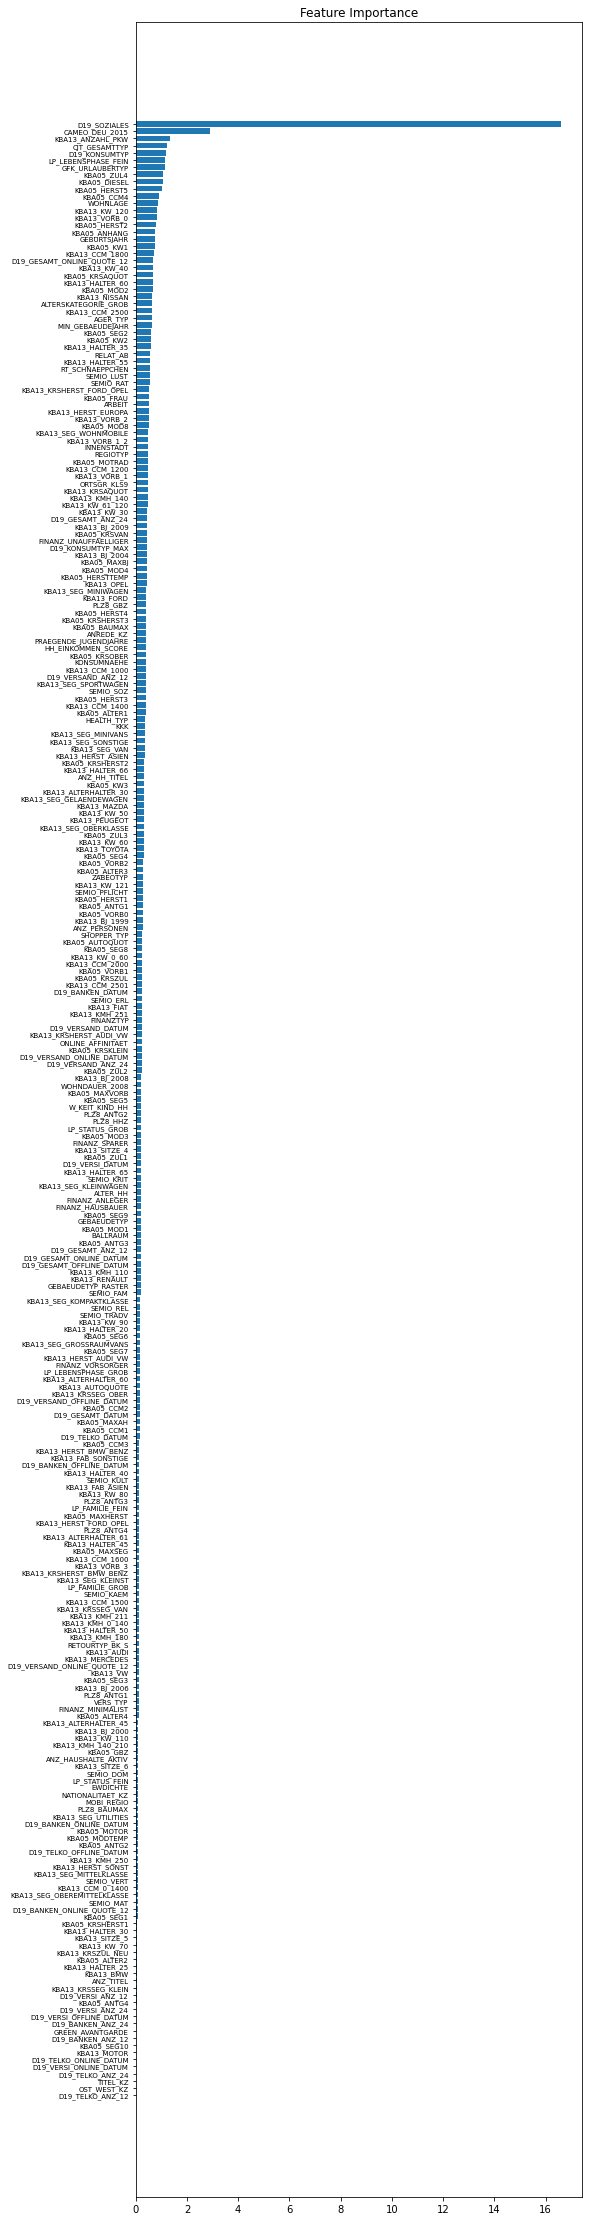

In [222]:

feature_importance = cbc.feature_importances_
sorted_idx = np.argsort(feature_importance)
my_dpi = 150
plt.figure(figsize=(1200/my_dpi, 3000/my_dpi), dpi=my_dpi)
plt.rc('ytick', labelsize=7) 

fig = plt.figure(figsize=(8, 40))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

# Credits: 
# https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-using-catboost


C:\Users\Jose Yanez\AppData\Local\Temp\ipykernel_4884\317071598.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')


{'KBA13_ANTG2', 'D19_TELKO_ONLINE_QUOTE_12', 'UMFELD_JUNG', 'STRUKTURTYP', 'D19_TIERARTIKEL', 'D19_REISEN', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND2', 'KONSUMZELLE', 'CAMEO_INTL_2015', 'D19_BUCH_CD', 'D19_GARTEN', 'D19_DIGIT_SERV', 'ALTERSKATEGORIE_FEIN', 'D19_BEKLEIDUNG_REST', 'HH_DELTA_FLAG', 'D19_SCHUHE', 'D19_BANKEN_LOKAL', 'KK_KUNDENTYP', 'D19_DROGERIEARTIKEL', 'D19_VERSICHERUNGEN', 'KBA13_CCM_3001', 'D19_LOTTO', 'VHN', 'SOHO_KZ', 'VERDICHTUNGSRAUM', 'ANZ_KINDER', 'CJT_TYP_4', 'D19_BANKEN_DIREKT', 'VK_ZG11', 'D19_TELKO_REST', 'KBA13_GBZ', 'CJT_TYP_3', 'D19_HAUS_DEKO', 'UNGLEICHENN_FLAG', 'D19_RATGEBER', 'D19_NAHRUNGSERGAENZUNG', 'KBA13_KMH_210', 'KOMBIALTER', 'KBA13_HHZ', 'D19_BEKLEIDUNG_GEH', 'VK_DISTANZ', 'D19_KOSMETIK', 'AKT_DAT_KL', 'MOBI_RASTER', 'D19_ENERGIE', 'VK_DHT4A', 'KBA13_BAUMAX', 'LNR', 'D19_KINDERARTIKEL', 'UMFELD_ALT', 'RT_UEBERGROESSE', 'ALTER_KIND4', 'D19_BILDUNG', 'CJT_TYP_5', 'DSL_FLAG', 'D19_HANDWERK', 'EINGEFUEGT_AM', 'D19_LEBENSMITTEL', 'KBA13_ANTG4', 'FIRM

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# Submit for Kaggle

mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
kaggle1 = replace_mv(mailout_test,coded_mv)
kaggle2 = preprocessing_train(kaggle1)
kaggle3 = high_mv_imputation(kaggle2,cols_high_mv)
LNR = mailout_test_kaggle[['LNR']]

pred_cb = cbc.predict_proba(kaggle3)[:,1]
pred_cb = pd.DataFrame(pred_cb)
submit_cb = pd.concat([LNR,pred_cb],axis=1)
submit_cb.columns = ['LNR','RESPONSE']

submit_model_1.to_csv('submit_cb_2.csv', index=False)

## End of the Modelling Process


The code below is part of the iterative process for testing, transforming y and creating new features for the problem

In [ ]:
#pd.crosstab(mailout_test['CAMEO_DEU_2015'], mailout_test['RESPONSE'])
rev = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
ct1 = pd.crosstab(rev['CAMEO_DEU_2015'],rev['RESPONSE'])

(ct1.iloc[:,1]/ct1.iloc[:,0] >  rev['RESPONSE'].mean()).astype(int).reset_index()

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(ct1)
print(stat)
print(p)
print(dof)



In [ ]:
feature_cols = set(rev.columns)-set(['LNR','RESPONSE'])
from scipy.stats import chi2_contingency

feature_names = []
chisq_value = []

for i in feature_cols:
    print(i)
    
    try:
        crosstab_temp = pd.crosstab(rev[i],rev['RESPONSE'])
        feature_names.append(i)
        stat, p, dof, expected = chi2_contingency(crosstab_temp)
        chisq_value.append(stat)
    except:
        print(f"feature failed")


In [ ]:
df = pd.DataFrame(list(zip(feature_names, chisq_value)),
               columns =['Feature', 'Chi2'])
df = df.sort_values(by='Chi2',ascending = False)

df[df['Chi2']>50].plot.bar()
plt.show()
print(df[df['Chi2']>40])


In [ ]:
# Feature Engineering of ANZ_HAUSHALTE_AKTIV
ct1 = pd.crosstab(rev['ANZ_HAUSHALTE_AKTIV'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  rev['RESPONSE'].mean()).astype(int).reset_index()
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)

t = pd.concat([s,x], axis=1 )

t.columns = ['Type','no_customer','customer','typ2','relevant']

t[t['relevant']==1] #1,3,4,5,8,9




In [ ]:
# Feature engineering CAMEO_INTL_2015

ct1 = pd.crosstab(rev['CAMEO_INTL_2015'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  (rev['RESPONSE'].mean())).astype(int).reset_index()
z = ct1.iloc[:,1]/ct1.iloc[:,0]
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)
t = pd.concat([s,x], axis=1 )
t.columns = ['Type','no_customer','customer','typ2','relevant']
t[t['relevant']==1] #

pd.crosstab(rev['CAMEO_INTL_2015'].isna(),rev['RESPONSE'])

#ct1.iloc[:,1]/ct1.iloc[:,0]

In [ ]:
# Feature engineering D19_KONSUMTYP 
ct1 = pd.crosstab(rev['D19_KONSUMTYP'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  (rev['RESPONSE'].mean())*0.8).astype(int).reset_index()
z = ct1.iloc[:,1]/ct1.iloc[:,0]
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)
t = pd.concat([s,x], axis=1 )
t.columns = ['Type','no_customer','customer','typ2','relevant']
t[t['relevant']==1] #1,3,4,5,8,9

# test feature

dict_d19konsumtyp = {1.0:1,2.0:2,3.0:3}

test = rev['D19_KONSUMTYP'].map(dict_d19konsumtyp).fillna(0).astype(int)
calc = pd.crosstab(test,rev['RESPONSE'])
print(calc)
stat, p, dof, expected = chi2_contingency(calc)
print(stat)

In [ ]:
# Feature engineering of GEBURTSJAHR
ct1 = pd.crosstab(rev['GEBURTSJAHR'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  (rev['RESPONSE'].mean())*0.8).astype(int).reset_index()
z = ct1.iloc[:,1]/ct1.iloc[:,0]
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)

t = pd.concat([s,x], axis=1 )
t.columns = ['Type','no_customer','customer','typ2','relevant']



rev['GEBURTSJAHR'].value_counts()
print(t[t['relevant']==1])


#test of feature

dict_geburtsjahr = {0:1, 1930:1,1931:1,1932:1,1936:1,1938:1,1946:1,1940:1,1941:1,1948:1,1958:1}

test = rev['GEBURTSJAHR'].map(dict_geburtsjahr).fillna(0).astype(int)
ct2 = pd.crosstab(test,rev['RESPONSE'])
stat, p, dof, expected = chi2_contingency(ct2)
print(stat)

In [ ]:
# Feature engineering of ANZ_STATISTICHE_HAUSHALTE
ct1 = pd.crosstab(rev['ANZ_STATISTISCHE_HAUSHALTE'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  rev['RESPONSE'].mean()).astype(int).reset_index()
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)

t = pd.concat([s,x], axis=1 )
t.columns = ['Type','no_customer','customer','typ2','relevant']

t[t['relevant']==1] #1.0 2.0 8.0 9.0 10.0 11.0 13.0 14.0


In [ ]:
# Feature engineering of CAMEO_DEU_2015    

ct1 = pd.crosstab(rev['CAMEO_DEU_2015'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  rev['RESPONSE'].mean()).astype(int).reset_index()
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)

t = pd.concat([s,x], axis=1 )
t.columns = ['Type','no_customer','customer','typ2','relevant']

t[t['relevant']==1] 


## Test of feature
dict_cameo = {'8A':1, '6B':1,'4C':1,'3D':1,
              '3C':1,'2D':1,'5D':1,'1A':1,
              '1E':1,'1B':1,'9C':1,'9D':1,
              '5B':1,'5C':1,'2A':1,'5A':1,
              '7C':1}

test = rev['CAMEO_DEU_2015'].map(dict_cameo).fillna(0).astype(int)


ct2 = pd.crosstab(test,rev['RESPONSE'])
stat, p, dof, expected = chi2_contingency(ct2)
print(stat)
print(ct2)

pd.crosstab(rev['CAMEO_DEU_2015'].isna(),rev['RESPONSE'])
ct1.iloc[:,1]/ct1.iloc[:,0]

In [ ]:
# Feature Engineering RT_SCHNAEPPCHEN

ct1 = pd.crosstab(rev['RT_SCHNAEPPCHEN'],rev['RESPONSE'])
print(ct1)

x = (ct1.iloc[:,1]/ct1.iloc[:,0] >  rev['RESPONSE'].mean()).astype(int).reset_index()
s = ct1.reset_index()
print(ct1.shape)
print(x.shape)

t = pd.concat([s,x], axis=1 )
t.columns = ['Type','no_customer','customer','typ2','relevant']

t[t['relevant']==1] 
# test feature

dict_rt = {5.0:1}
test = rev['RT_SCHNAEPPCHEN'].map(dict_rt).fillna(0).astype(int)

pd.crosstab(test,rev['RESPONSE'])
ct2 = pd.crosstab(test,rev['RESPONSE'])
stat, p, dof, expected = chi2_contingency(ct2)
print(stat)

In [ ]:
#Feature engineering of EINGEFUEGT_AM
import datetime
date = '2021-05-21 11:22:03'
datem = datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
print(datem.day)        # 25
print(datem.month)      # 5
print(datem.year)       # 2021
print(datem.hour)       # 11
print(datem.minute)     # 22
print(datem.second)     # 3


In [ ]:
#datetime.datetime.strptime(rev['EINGEFUEGT_AM'], "%Y-%m-%d %H:%M:%S")
rev['EINGEFUEGT_AM']
time_feature= pd.to_datetime(rev['EINGEFUEGT_AM'], format="%Y-%m-%d %H:%M:%S")
ct1 = pd.crosstab(time_feature.dt.year,rev['RESPONSE'])
print(ct1)
(ct1.iloc[:,1]/ct1.iloc[:,0] >  rev['RESPONSE'].mean()).astype(int).reset_index()
stat, p, dof, expected = chi2_contingency(ct1)
print(stat)

(pd.to_datetime(rev['EINGEFUEGT_AM'], format="%Y-%m-%d %H:%M:%S").dt.year<=1997).astype(int).mean()

# Test of feature
dict_year = {1992.0:2,1993.0:1,1994.0:1,1995:1,1996:1,1997:1}
dict_year2 = {1992.0:1}
test = (pd.to_datetime(rev['EINGEFUEGT_AM'], format="%Y-%m-%d %H:%M:%S")).dt.year.map(dict_year2).fillna(0).astype(int)
test

ct2 = pd.crosstab(test,rev['RESPONSE'])
stat, p, dof, expected = chi2_contingency(ct2)
print(stat)

ct2

In [ ]:
iterate_cols = set(rev.columns)-set(['LNR','RESPONSE'])

for i in iterate_cols:
    temp = pd.crosstab(rev[i].isna(),rev['RESPONSE'])
    stat, p, dof, expected = chi2_contingency(temp)
    print(f"{i} {stat}")
    


In [ ]:
rev['EINGEFUEGT_AM'].head

In [ ]:
# Tip for recoding some values and keep the rest with a default value
#df['col'] = df.col.map({'Mr': 0, 'Mrs': 1, 'Miss': 2}).fillna(3).astype(int)
#Source: https://stackoverflow.com/questions/39104730/pandas-replace-with-default-value

test = rev['D19_SOZIALES']
test.map({1.0: 1}).fillna(0).astype(int)

test2 = rev['D19_KONSUMTYP_MAX']
test2.map({2:1}).fillna(0).astype(int)

In [ ]:
#Finging subgroups with with % of customers

cols_to_iterate = set(rev.columns)-set(['LNR','RESPONSE'])

cols_to_iterate

for i in cols_to_iterate:
    temp = rev.groupby(i).agg({'RESPONSE': ['mean', 'std','count','sum']}).reset_index()
    temp.columns = [i,'mean','std','count','sum']
    x = temp[(temp['sum']>50) & (temp['mean']>0.016)]
    
    if x.shape[0]>0:
        print(x)
        print(temp.agg({'mean':['std']}))

In [ ]:
# Finding features with high variance in mean percentage of customers
std_devs = []
for i in cols_to_iterate:
    temp = rev.groupby(i).agg({'RESPONSE': ['mean', 'std','count','sum']}).reset_index()
    temp.columns = [i,'mean','std','count','sum']
    x = temp[(temp['sum']>50) & (temp['mean']>0.015)]
    #print(temp)
    if x.shape[0]>0:
        next
    
    sd = temp.agg({'mean':['std']}).values.astype(float)[0][0]
    std_devs.append(sd)
    if sd > 0.010:
        print(f"{i} has a standar deviation of: {sd}")
        print(temp)

In [ ]:
std_devs

In [ ]:
rev.groupby(['RT_SCHNAEPPCHEN']).agg({'RESPONSE': ['mean', 'std','count','sum']}).reset_index()



In [ ]:
#Testing the features

dict_KBA05_BAUMAX = {0.0:1,1.0:1}
dict_KBA13_BAUMAX = {1.0:1}
dict_D19_KONSUMTYP = {3.0:3, 2.0:2,1.0:1}
dict_KBA05_SEG6 = {0.0:1,1.0:2,9.0:3}
dict_ANZ_KINDER = {6.0:2,3.0:2,0.0:2,1.0:1,2:1}
dict_RT_SCHNAEPPCHEN = {5.0: 2, 1.0: 1, 2.0: 1, 3.0:1, 4.0:1}

def chsq(feature, dic):
    
    test = rev[feature].map(dic).fillna(0).astype(int)
    ct = pd.crosstab(test,rev['RESPONSE'])
    stat, p, dof, expected = chi2_contingency(ct)
    print(ct)
    print(f"{feature}: {stat}")

chsq('KBA05_BAUMAX',dict_KBA05_BAUMAX)
chsq('KBA13_BAUMAX',dict_KBA13_BAUMAX)
chsq('D19_KONSUMTYP',dict_D19_KONSUMTYP) #This work
chsq('KBA05_SEG6',dict_KBA05_SEG6) # 12.54
chsq('ANZ_KINDER',dict_ANZ_KINDER) # Not enough
chsq('RT_SCHNAEPPCHEN',dict_RT_SCHNAEPPCHEN) # 61.1

